In [12]:
from google.colab import drive
import pandas as pd
import numpy as np
import requests
import glob
import re
import os

## Загрузка

In [2]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/vacancy/image_review_all.json'
muilti = pd.read_json(file_path, lines=True, nrows=100)


Mounted at /content/drive


In [3]:
business_id = []
user_id = []
rating = []
review_text = []
pic_ids = []
pic_urls = []


for i in range(len(muilti)):
  business_id.append(muilti["business_id"][i])
  user_id.append(int(muilti["user_id"][i]))
  rating.append(muilti["rating"][i])
  review_text.append(muilti["review_text"][i])
  a = []
  b = []
  for pic in muilti["pics"]:
    temp = pic
    for k in range(len(temp)):
      a.append(temp[k]["id"])
      element = temp[k]["url"]
      for l in range(len(element)):
        b.append(str(element[l]))
  pic_ids.append(", ".join(a))
  pic_urls.append(", ".join(b))

data = pd.DataFrame({"business_id": business_id, "user_id":user_id, "rating":rating, "review_text":review_text, "pic_ids": pic_ids, "pic_urls":pic_urls})
print(data.head())

                business_id                user_id  rating  \
0  605730f68cd0e3d69a52284b  113890892872599846912       4   
1  605730f68cd0e3d69a52284b  100158382312395997184       5   
2  605730f68cd0e3d69a52284b  113495161718980116480       2   
3  605730f68cd0e3d69a52284b  111259544401075257344       3   
4  605730f68cd0e3d69a52284b  104285463275063918592       5   

                                         review_text  \
0  We came for a birthday brunch and this place i...   
1  Cool place to hang out, have drinks.  There is...   
2  This place doesn’t rock the senses when it com...   
3  Pretty cool place to hang out with friends and...   
4  We saw this place the other day when we had re...   

                                             pic_ids  \
0  AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ, ...   
1  AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ, ...   
2  AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ, ...   
3  AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ, ...   
4  AF1QipP

## Связка

In [4]:
!mkdir images
failed_list = []

for index, row in data.iterrows():
    image_urls = row['pic_urls'].split(',')
    for i, url in enumerate(image_urls):
        response = requests.get(url.strip())
        if response.status_code == 200:
          filename = url.split('/')[-1].split('?')[0] + '.jpg'
          with open(f'images/{filename}', 'wb') as f:
            f.write(response.content)
        else:
          failed_list.append(url)
          print(f"Failed to download image from {url}")

Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipPvjCeaD_qm6CkMEcWGW8xPZT6TYNfKA5EYfGuI=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipM9m-gcQ0aOHl9x1tBn2wVbg-QXXfW-_l6ftxeU=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipN_Q4Hke7N6igMJ7RQw4wV2c35FnFznQsFZTGjJ=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipOP5KJnse_Tgl33LuCc0XK2xvkdNP75IJvT1rfO=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipMc1TWDQDdEZOefV3Eu7da2rIWps0XH8Dwve9FP=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipPH6oQS4OYhgdPqCQmwMr-_j5FoH9T7La8McLBr=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipMJpmM_Hwa6YJYjs66viwc3Gs32W2dPDlr0sis6=w150-h150-k-no-p
Failed to download image from  https://lh5.googleusercontent.com/p/AF1QipPvjCeaD_qm6CkMEcWGW8xPZT

In [31]:
image_filenames = glob.glob("/images/*.jpg")
for name in image_filenames:
  re.sub('*/.jpg', '', name)
for i in range(len(data)):
  image_urls = list(data[i].get('pic_urls'))
  if image_urls is not None:
    image_urls = image_urls.split(',')
    if image_urls not in image_filenames:
      data.drop([i], inplace=True)
  else:
    continue


KeyError: ignored

## Предобработка

In [8]:
!pip install nltk pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=542bf9bc9299e96ea6eb10af080aa5d45d9b7a93528ac8e17ac12ad539db7c51
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def process_text(text):
  if type(text) == str:
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    lemmatized_words = [morph.parse(word)[0].normal_form for word in tokens]
    return ' '.join(lemmatized_words)

data['review_text'] = data['review_text'].apply(process_text)

In [14]:
import cv2

folder_path = "images"

for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        normalized_image = image.astype('float32') / 255.0
        cv2.imwrite(image_path, (normalized_image * 255).astype('uint8'))



## EDA

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 1 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  99 non-null     object
 1   user_id      99 non-null     object
 2   rating       99 non-null     int64 
 3   review_text  99 non-null     object
 4   pic_ids      99 non-null     object
 5   pic_urls     99 non-null     object
dtypes: int64(1), object(5)
memory usage: 7.5+ KB


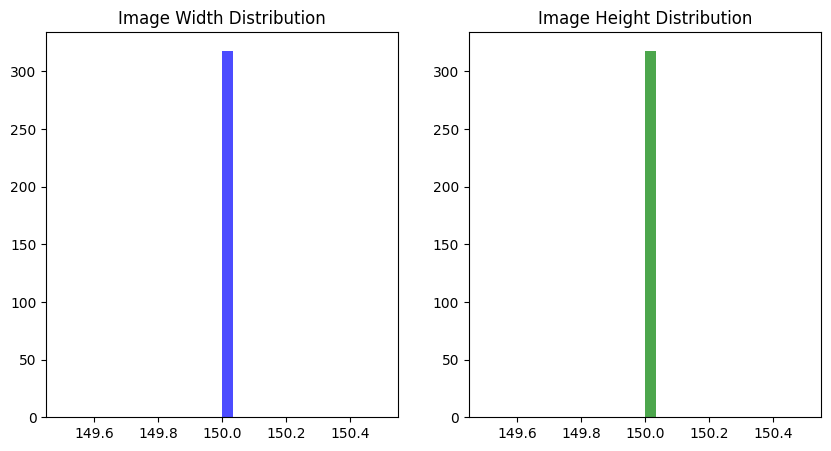

In [16]:
import cv2
import matplotlib.pyplot as plt
import os

folder_path = "images"

sizes = []
pixel_values = []
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        pixel_values.append(image.flatten())
        sizes.append(image.shape[:2])

sizes = np.array(sizes)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(sizes[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Image Width Distribution')
plt.subplot(1, 2, 2)
plt.hist(sizes[:, 1], bins=30, color='green', alpha=0.7)
plt.title('Image Height Distribution')
plt.show()


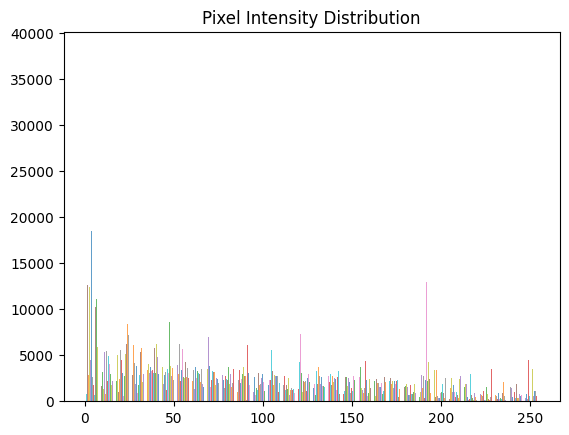

In [18]:
plt.hist(pixel_values, bins=30, alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.show()

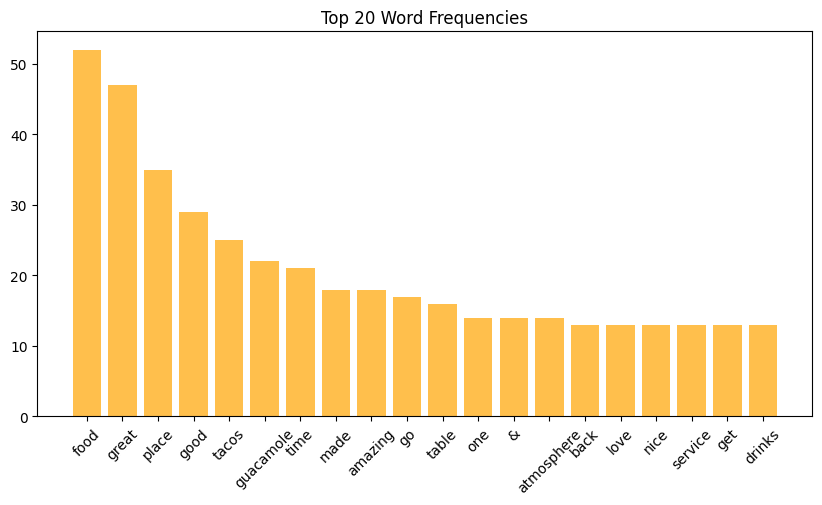

In [22]:
from collections import Counter

words = [word for sentence in data['review_text'] for word in sentence.split()]
word_freq = Counter(words)

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_word_freq.index[:20], df_word_freq['Frequency'][:20], color='orange', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Top 20 Word Frequencies')
plt.show()


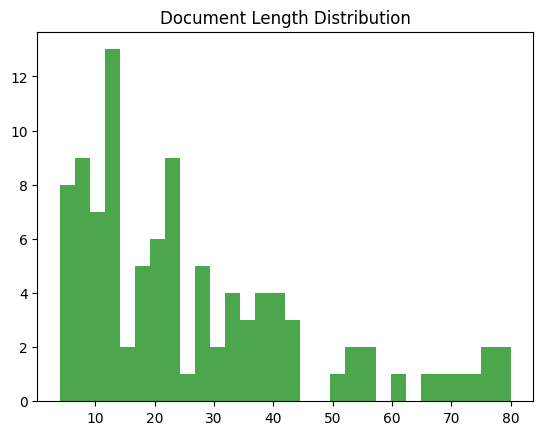

In [23]:
document_lengths = [len(sentence.split()) for sentence in data['review_text']]
plt.hist(document_lengths, bins=30, color='green', alpha=0.7)
plt.title('Document Length Distribution')
plt.show()